# Read and process soil water content sensors


location of soil sensors and their numbers											
						
|Port| Sensor No | Place| depth | mTAW |
|:-----------:|:-----------:|:--------------------:|:--------------------------------:|:---------------:|
|   1   |  37   |  1 | 70 |  
|   2   |  3    |  1 | 40 |  
|   4   |  28   |  1 | 20 |  
|   5   |  41   |  2 | 70 | 
|   7   |  29   |  2 | 20 | 
|   8   |  4  |  2 | 40 | 
|   10  |  x   |  3 | x |  
|   11  |  x   |  3 | x |  
|   12  |  x   |  3 | x | 


# Import Python modules

In [78]:
import pandas as pd
import xlrd
import os
import numpy as np
import glob
import matplotlib.pyplot as plt
#from pandasql import sqldf
import datetime
import csv
import pdb
from tqdm.notebook import tqdm
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import FuncFormatter
from matplotlib.legend import Legend
def minor_formatter(x, ind):
    # only format if we don't overlap with a major tick
    if np.mod(x, 1) < .1:
        return ''
    return '{:.1f}'.format(np.mod(x, 1))
def alternate_formatter(x, ind):
    rm = np.mod(x, 1)
    if np.abs(rm) < .1:
        return '{:d}'.format(int(x))
    return '{:.1f}'.format(rm)

# Read data file

In [79]:
path1 = os.getcwd()
path = os.path.join(path1, 'Data_Callibration')
file = os.path.join(path, 'RawData.csv')
Cal = pd.read_csv(file,sep=';', header=0)
print(Cal)

    SensorNumber   RawValue  KnownVWC
0              7  27.192825     0.353
1              7  25.560288     0.254
2              7  23.913115     0.209
3             28  27.711502     0.353
4             28  26.337332     0.254
5             28  24.516957     0.209
6             41  28.118244     0.353
7             41  26.337332     0.254
8             41  24.753454     0.209
9             43  27.192825     0.353
10            43  25.218349     0.254
11            43  23.913115     0.209
12             3  28.418761     0.353
13             3  26.337332     0.254
14             3  25.446928     0.209
15            29  28.418761     0.353
16            29  25.673040     0.254
17            29  24.635553     0.209
18             4  28.617026     0.353
19             4  26.446092     0.254
20             4  25.332952     0.209
21            37  28.218839     0.353
22            37  26.554316     0.254
23            37  25.103109     0.209
24             5  28.319010     0.353
25          

In [80]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

KV = Cal['KnownVWC']
RV = pd.to_numeric(Cal.RawValue)
SN = Cal.SensorNumber
df = pd.DataFrame(dict(KnownVWC = KV, RawValue=RV, SensorNumber = SN))
print(df)

plt.show()

    KnownVWC   RawValue  SensorNumber
0      0.353  27.192825             7
1      0.254  25.560288             7
2      0.209  23.913115             7
3      0.353  27.711502            28
4      0.254  26.337332            28
5      0.209  24.516957            28
6      0.353  28.118244            41
7      0.254  26.337332            41
8      0.209  24.753454            41
9      0.353  27.192825            43
10     0.254  25.218349            43
11     0.209  23.913115            43
12     0.353  28.418761             3
13     0.254  26.337332             3
14     0.209  25.446928             3
15     0.353  28.418761            29
16     0.254  25.673040            29
17     0.209  24.635553            29
18     0.353  28.617026             4
19     0.254  26.446092             4
20     0.209  25.332952             4
21     0.353  28.218839            37
22     0.254  26.554316            37
23     0.209  25.103109            37
24     0.353  28.319010             5
25     0.254

In [81]:
file = os.path.join(path, 'dacom_weather_data.csv')
#climate data from  www.dacom.nl
clim=pd.read_csv(file,sep=';')
clim['date'] = pd.to_datetime(clim['date'], format = '%m/%d/%Y')
print(clim)

climday = clim.groupby(clim.date.dt.floor('d')).agg({'precipitation': ['sum']})
climday.columns  = ['_'.join(col) for col in climday.columns.values]
climday.reset_index(inplace=True)
print(climday)


           date      time  air_temperature  rel_humidity  precipitation  \
0    2022-05-17  12:00 AM            15.57         90.16            0.0   
1    2022-05-17   1:00 AM            15.20         95.71            0.0   
2    2022-05-17   2:00 AM            15.11         97.59            0.0   
3    2022-05-17   3:00 AM            14.91         92.53            0.0   
4    2022-05-17   4:00 AM            14.72        100.00            0.0   
...         ...       ...              ...           ...            ...   
4547 2022-11-22  10:00 AM             6.02        100.00            0.0   
4548 2022-11-22  11:00 AM             6.46        100.00            0.0   
4549 2022-11-22  12:00 PM             7.03        100.00            0.0   
4550 2022-11-22   1:00 PM             7.73        100.00            0.0   
4551 2022-11-22   2:00 PM             8.30        100.00            0.0   

      wind_speed  wind_direction  radiation  radiation_short  
0           0.54          164.34    

# Plot data

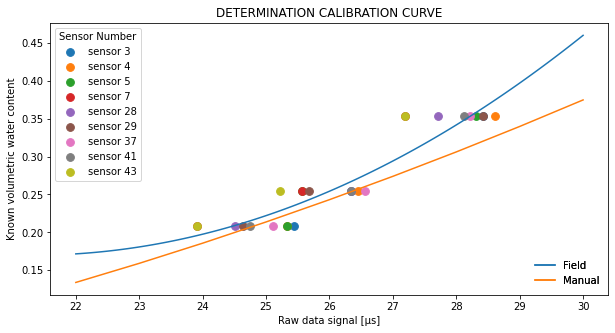

          2
0.003844 x - 0.1638 x + 1.916
0.8835858446749271


In [82]:
from sklearn.metrics import r2_score
import scipy.stats as stats

xx = np.arange(22,31)
yy = 0.0007*xx**2 - 0.0063*xx - 0.0663

model = np.poly1d(np.polyfit(Cal['RawValue'],
                             Cal['KnownVWC'], 2))
polyline = np.linspace(22, 30, 100)
fig, ax = plt.subplots(figsize=(10,5))


for i in range(44):
    if(i not in Cal.SensorNumber.tolist()):
        continue
    else:
        sensorMeasurements = Cal.loc[Cal['SensorNumber'] == i]
        scatter = ax.scatter(sensorMeasurements.RawValue, sensorMeasurements.KnownVWC, label=f"sensor {i}"
            , alpha=1, s=60)

legend = ax.legend(title="Sensor Number")
ax.add_artist(legend)

field, = plt.plot(polyline, model(polyline))
manual, = plt.plot(xx,yy)


leg = ax.legend( handles = [field, manual], labels = ['Field', 'Manual'],
               loc='lower right', frameon=False)
ax.add_artist(leg);

ax.set_ylabel('Known volumetric water content')
ax.set_xlabel('Raw data signal [µs]')
ax.set_title('DETERMINATION CALIBRATION CURVE')

plt.show()

print(model)
print(r2_score(Cal['KnownVWC'], 
               model(Cal['RawValue'])))
  

# Import field data

In [83]:
path1 = os.getcwd()
path = os.path.join(path1, 'Data_Callibration')
file = os.path.join(path, 'FieldData3.csv')
Field = pd.read_csv(file,sep=';', header=0)
Field1 = Field.iloc[:,0:38]
Data = Field1.iloc[:,[5,7,9,11,13,15,17,19,21,23,27,29,33,35,37]]
Data = Data.replace('NAN',np.nan)
Data = Data.fillna(0)
Data = Data.astype(float)
#Data['PA_uS_Avg(7)'] = Data['PA_uS_Avg(7)'] + Data['PA_uS_Avg(3)']
#Data['PA_uS_Avg(8)'] = Data['PA_uS_Avg(8)'] + Data['PA_uS_Avg(6)']
#Data.loc[:40,'PA_uS_Avg(3)'] = 0
#Data.loc[:40,'PA_uS_Avg(6)'] = 0
print(Data)
Data.to_excel('RawSignals.xlsx')


      PA_uS_Avg(1)  PA_uS_Avg(2)  PA_uS_Avg(3)  PA_uS_Avg(4)  PA_uS_Avg(5)  \
0            26.74         24.24           0.0          0.00          0.00   
1            27.16         26.50           0.0         25.39         25.83   
2            27.17         26.50           0.0         25.40         25.84   
3            27.18         26.50           0.0         25.40         25.84   
4            27.18         26.51           0.0         25.41         25.85   
...            ...           ...           ...           ...           ...   
2976         30.33         28.25           0.0         28.13         30.88   
2977         30.33         28.25           0.0         28.12         30.88   
2978         30.33         28.25           0.0         28.12         30.88   
2979         30.33         28.25           0.0         28.12         30.88   
2980         30.33         28.25           0.0         28.12         30.87   

      PA_uS_Avg(6)  PA_uS_Avg(7)  PA_uS_Avg(8)  PA_uS_Avg(9)  P

# Calculate volumetric water content

In [84]:
c=len(Data.columns) 
print(c)
r=len(Data)
print(r)
ColumnNumber = list(range(0, c))
print(ColumnNumber)
VWC = np.zeros((r,c))
print(VWC)

15
2981
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [85]:
for i in ColumnNumber:
    VWC[:,i] = 0.003844*Data.iloc[:,i]**2 - 0.1638*Data.iloc[:,i] + 1.916
print(VWC)

[[0.28455409 0.20413629 1.916      ... 1.916      1.916      1.916     ]
 [0.30277857 0.274749   1.916      ... 1.916      1.916      1.916     ]
 [0.30322901 0.274749   1.916      ... 1.916      1.916      1.916     ]
 ...
 [0.48407581 0.35640225 1.916      ... 1.916      0.60901322 0.55729685]
 [0.48407581 0.35640225 1.916      ... 1.916      0.60901322 0.55729685]
 [0.48407581 0.35640225 1.916      ... 1.916      0.60983422 0.55729685]]


In [86]:
VWC[VWC>1] = np.nan
print(VWC)

[[0.28455409 0.20413629        nan ...        nan        nan        nan]
 [0.30277857 0.274749          nan ...        nan        nan        nan]
 [0.30322901 0.274749          nan ...        nan        nan        nan]
 ...
 [0.48407581 0.35640225        nan ...        nan 0.60901322 0.55729685]
 [0.48407581 0.35640225        nan ...        nan 0.60901322 0.55729685]
 [0.48407581 0.35640225        nan ...        nan 0.60983422 0.55729685]]


In [87]:
VWC = pd.DataFrame(VWC)
VWC.columns =['a70','a40','d20/1','a20','b70','d40/1','b20','b40','d70/1','d20/2','d20/3','d40/3','d40/2','d70/3','d70/2']
print(VWC)

           a70       a40  d20/1       a20       b70  d40/1       b20  \
0     0.284554  0.204136    NaN       NaN       NaN    NaN  0.182871   
1     0.302779  0.274749    NaN  0.235161  0.249720    NaN  0.238339   
2     0.303229  0.274749    NaN  0.235475  0.250068    NaN  0.238661   
3     0.303680  0.274749    NaN  0.235475  0.250068    NaN  0.238661   
4     0.303680  0.275149    NaN  0.235790  0.250417    NaN  0.238984   
...        ...       ...    ...       ...       ...    ...       ...   
2976  0.484076  0.356402    NaN  0.350051  0.523396    NaN  0.356936   
2977  0.484076  0.356402    NaN  0.349527  0.523396    NaN  0.356402   
2978  0.484076  0.356402    NaN  0.349527  0.523396    NaN  0.356402   
2979  0.484076  0.356402    NaN  0.349527  0.523396    NaN  0.356402   
2980  0.484076  0.356402    NaN  0.349527  0.522660    NaN  0.356402   

           b40  d70/1     d20/2  d20/3     d40/3  d40/2     d70/3     d70/2  
0          NaN    NaN       NaN    NaN       NaN    NaN  

In [88]:
Plotdata = Field1.iloc[:,0]
print(Plotdata)

0       2022-09-20 14:00:00
1       2022-09-20 14:30:00
2       2022-09-20 15:00:00
3       2022-09-20 15:30:00
4       2022-09-20 16:00:00
               ...         
2976    2022-11-21 14:00:00
2977    2022-11-21 14:30:00
2978    2022-11-21 15:00:00
2979    2022-11-21 15:30:00
2980    2022-11-21 16:00:00
Name: TIMESTAMP, Length: 2981, dtype: object


In [89]:
Plotdata = pd.concat([Plotdata, VWC], axis="columns")
print(Plotdata)


                TIMESTAMP       a70       a40  d20/1       a20       b70  \
0     2022-09-20 14:00:00  0.284554  0.204136    NaN       NaN       NaN   
1     2022-09-20 14:30:00  0.302779  0.274749    NaN  0.235161  0.249720   
2     2022-09-20 15:00:00  0.303229  0.274749    NaN  0.235475  0.250068   
3     2022-09-20 15:30:00  0.303680  0.274749    NaN  0.235475  0.250068   
4     2022-09-20 16:00:00  0.303680  0.275149    NaN  0.235790  0.250417   
...                   ...       ...       ...    ...       ...       ...   
2976  2022-11-21 14:00:00  0.484076  0.356402    NaN  0.350051  0.523396   
2977  2022-11-21 14:30:00  0.484076  0.356402    NaN  0.349527  0.523396   
2978  2022-11-21 15:00:00  0.484076  0.356402    NaN  0.349527  0.523396   
2979  2022-11-21 15:30:00  0.484076  0.356402    NaN  0.349527  0.523396   
2980  2022-11-21 16:00:00  0.484076  0.356402    NaN  0.349527  0.522660   

      d40/1       b20       b40  d70/1     d20/2  d20/3     d40/3  d40/2  \
0       NaN

In [90]:
Plotdata1 = Plotdata.drop(Plotdata.index[0:137])
print(Plotdata1)

                TIMESTAMP       a70       a40  d20/1       a20       b70  \
137   2022-09-23 10:30:00  0.309616  0.240283    NaN  0.244589  0.479927   
138   2022-09-23 11:00:00  0.310541  0.240283    NaN  0.244589  0.481307   
139   2022-09-23 11:30:00  0.309616  0.239957    NaN  0.243584  0.481307   
140   2022-09-23 12:00:00  0.309155  0.240283    NaN  0.242918  0.481307   
141   2022-09-23 12:30:00  0.309155  0.240609    NaN  0.243251  0.481998   
...                   ...       ...       ...    ...       ...       ...   
2976  2022-11-21 14:00:00  0.484076  0.356402    NaN  0.350051  0.523396   
2977  2022-11-21 14:30:00  0.484076  0.356402    NaN  0.349527  0.523396   
2978  2022-11-21 15:00:00  0.484076  0.356402    NaN  0.349527  0.523396   
2979  2022-11-21 15:30:00  0.484076  0.356402    NaN  0.349527  0.523396   
2980  2022-11-21 16:00:00  0.484076  0.356402    NaN  0.349527  0.522660   

      d40/1       b20       b40  d70/1     d20/2  d20/3     d40/3  d40/2  \
137     NaN

In [91]:
Timestamp = Plotdata1['TIMESTAMP']
Timestamp = pd.to_datetime(Timestamp)
a70 = Plotdata1['a70']
a40 = Plotdata1['a40']
a20 = Plotdata1['a20']
b70 = Plotdata1['b70']
b20 = Plotdata1['b20']
b40 = Plotdata1['b40']
d20w1 = Plotdata1['d20/1']
d40w1 = Plotdata1['d40/1']
d70w1 = Plotdata1['d70/1']
d20w2 = Plotdata1['d20/2']
d20w3 = Plotdata1['d20/3']
d40w3 = Plotdata1['d40/3']
d40w2 = Plotdata1['d40/2']
d70w3 = Plotdata1['d70/3']
d70w2 = Plotdata1['d70/2']
print(Timestamp)

137    2022-09-23 10:30:00
138    2022-09-23 11:00:00
139    2022-09-23 11:30:00
140    2022-09-23 12:00:00
141    2022-09-23 12:30:00
               ...        
2976   2022-11-21 14:00:00
2977   2022-11-21 14:30:00
2978   2022-11-21 15:00:00
2979   2022-11-21 15:30:00
2980   2022-11-21 16:00:00
Name: TIMESTAMP, Length: 2844, dtype: datetime64[ns]


(738421.0, 738481.0)

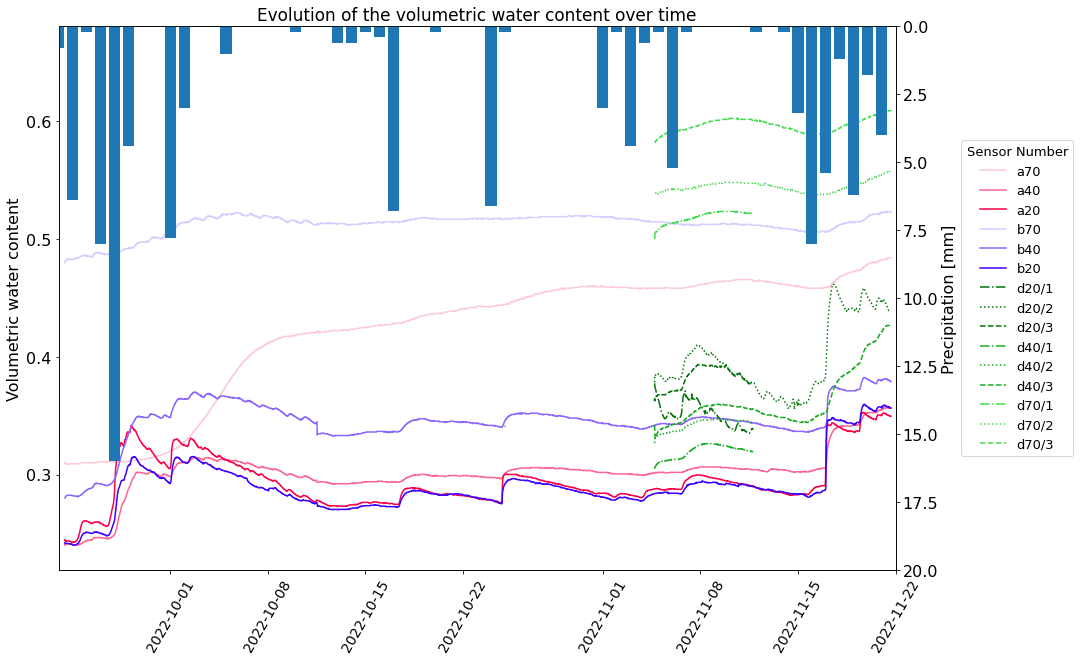

In [92]:
date1=datetime.date(2022,9,23)
date2=datetime.date(2022,11,22)
ftsz=16

fig, ax= plt.subplots(figsize=(15,10))
axb=ax.twinx()

ax.plot(Timestamp, a70, label='a70', color='#fccad8')
ax.plot(Timestamp, a40, label='a40', color='#fc6590')
ax.plot(Timestamp, a20, label='a20', color='#fc0048')
ax.plot(Timestamp, b70, label='b70', color='#d8ccff')
ax.plot(Timestamp, b40, label='b40', color ='#8a66ff')
ax.plot(Timestamp, b20, label='b20', color='#3c00ff')

ax.plot(Timestamp, d20w1, label='d20/1', color='#017309', linestyle = 'dashdot')
ax.plot(Timestamp, d20w2, label='d20/2', color='#017309', linestyle = 'dotted')
ax.plot(Timestamp, d20w3, label='d20/3', color='#017309', linestyle = 'dashed')

ax.plot(Timestamp, d40w1, label='d40/1', color='#1aab23', linestyle = 'dashdot')
ax.plot(Timestamp, d40w2, label='d40/2', color='#1aab23', linestyle = 'dotted')
ax.plot(Timestamp, d40w3, label='d40/3', color='#1aab23', linestyle = 'dashed')

ax.plot(Timestamp, d70w1, label='d70/1', color='#42db4c', linestyle = 'dashdot')
ax.plot(Timestamp, d70w2, label='d70/2', color='#42db4c', linestyle = 'dotted')
ax.plot(Timestamp, d70w3, label='d70/3', color='#42db4c', linestyle = 'dashed')

ax.set_title('Evolution of the volumetric water content over time', fontsize = ftsz+1)
ax.legend(title='Sensor Number',title_fontsize = ftsz-3, bbox_to_anchor = (1.22, 0.5), loc='center right', fontsize=ftsz-3)
ax.set_ylabel('Volumetric water content', fontsize= ftsz)
ax.tick_params(axis='x', which='both', labelsize=ftsz-2,rotation=60)
ax.tick_params(axis='y', which='both', labelsize=ftsz)
axb.bar(climday['date'],climday.precipitation_sum)
axb.set_ylim([0, 20])
axb.invert_yaxis()
axb.set_ylabel('Precipitation [mm]', fontsize= ftsz)
axb.tick_params(axis='x', which='both', labelsize=ftsz)
axb.tick_params(axis='y', which='both', labelsize=ftsz)

axb.set_xlim([date1,date2])

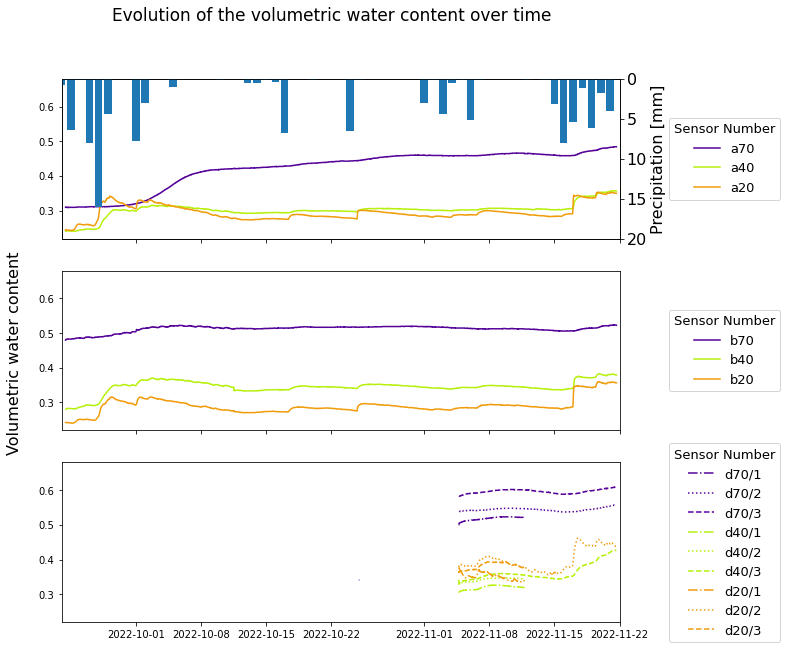

In [93]:
date1=datetime.date(2022,9,23)
date2=datetime.date(2022,11,22)
ftsz=16

fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True, figsize=(10,10))
fig.suptitle('Evolution of the volumetric water content over time', fontsize = ftsz+1)
axb=ax1.twinx()
ax1.plot(Timestamp, a70, label='a70', color='#550299')
ax1.plot(Timestamp, a40, label='a40', color='#b7f00c')
ax1.plot(Timestamp, a20, label='a20', color='#f09c0c')
ax1.legend(title='Sensor Number',title_fontsize = ftsz-3, bbox_to_anchor = (1.3, 0.5), loc='center right', fontsize=ftsz-3)
axb.bar(climday['date'],climday.precipitation_sum)
axb.set_ylim([0, 20])
axb.invert_yaxis()
axb.set_ylabel('Precipitation [mm]', fontsize= ftsz)
axb.tick_params(axis='x', which='both', labelsize=ftsz)
axb.tick_params(axis='y', which='both', labelsize=ftsz)
axb.set_xlim([date1,date2])

ax2.plot(Timestamp, b70, label='b70', color='#550299')
ax2.plot(Timestamp, b40, label='b40', color ='#b7f00c')
ax2.plot(Timestamp, b20, label='b20', color='#f09c0c')
ax2.legend(title='Sensor Number',title_fontsize = ftsz-3, bbox_to_anchor = (1.3, 0.5), loc='center right', fontsize=ftsz-3)

ax3.plot(Timestamp, d70w1, label='d70/1', color='#550299', linestyle = 'dashdot')
ax3.plot(Timestamp, d70w2, label='d70/2', color='#550299', linestyle = 'dotted')
ax3.plot(Timestamp, d70w3, label='d70/3', color='#550299', linestyle = 'dashed')

ax3.plot(Timestamp, d40w1, label='d40/1', color='#b7f00c', linestyle = 'dashdot')
ax3.plot(Timestamp, d40w2, label='d40/2', color='#b7f00c', linestyle = 'dotted')
ax3.plot(Timestamp, d40w3, label='d40/3', color='#b7f00c', linestyle = 'dashed')

ax3.plot(Timestamp, d20w1, label='d20/1', color='#f09c0c', linestyle = 'dashdot')
ax3.plot(Timestamp, d20w2, label='d20/2', color='#f09c0c', linestyle = 'dotted')
ax3.plot(Timestamp, d20w3, label='d20/3', color='#f09c0c', linestyle = 'dashed')
ax3.legend(title='Sensor Number',title_fontsize = ftsz-3, bbox_to_anchor = (1.3, 0.5), loc='center right', fontsize=ftsz-3)

fig.text(0.06, 0.5, 'Volumetric water content', ha='center', va='center', fontsize= ftsz, rotation='vertical')

plt.savefig("VWC.png", bbox_inches = 'tight')
